In [107]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#dl libraraies
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , concatenate
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers import dot
from keras.models import Model


#preprocess.
from keras.preprocessing.image import ImageDataGenerator

# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image


#TL pecific modules
from keras.applications.vgg16 import VGG16

In [108]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
print(tf.config.experimental.list_physical_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [109]:
ratings_cols = ["user_id", "movie_id", "rating", "timestamp"]
train = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_cols, encoding="latin-1",)
display(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


None

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [110]:
df=train.copy()

In [111]:
display(len(df['user_id'].unique()))
df['user_id'].unique()

943

array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6,  62, 286, 200,
       210, 224, 303, 122, 194, 291, 234, 119, 167, 299, 308,  95,  38,
       102,  63, 160,  50, 301, 225, 290,  97, 157, 181, 278, 276,   7,
        10, 284, 201, 287, 246, 242, 249,  99, 178, 251,  81, 260,  25,
        59,  72,  87,  42, 292,  20,  13, 138,  60,  57, 223, 189, 243,
        92, 241, 254, 293, 127, 222, 267,  11,   8, 162, 279, 145,  28,
       135,  32,  90, 216, 250, 271, 265, 198, 168, 110,  58, 237,  94,
       128,  44, 264,  41,  82, 262, 174,  43,  84, 269, 259,  85, 213,
       121,  49, 155,  68, 172,  19, 268,   5,  80,  66,  18,  26, 130,
       256,   1,  56,  15, 207, 232,  52, 161, 148, 125,  83, 272, 151,
        54,  16,  91, 294, 229,  36,  70,  14, 295, 233, 214, 192, 100,
       307, 297, 193, 113, 275, 219, 218, 123, 158, 302,  23, 296,  33,
       154,  77, 270, 187, 170, 101, 184, 112, 133, 215,  69, 104, 240,
       144, 191,  61, 142, 177, 203,  21, 197, 134, 180, 236, 26

In [112]:
display(len(df['movie_id'].unique()))
df['movie_id'].unique()

1682

array([ 242,  302,  377, ..., 1637, 1630, 1641], dtype=int64)

In [113]:
display(df['user_id'].isnull().sum())
display(df['movie_id'].isnull().sum())
display(df['rating'].isnull().sum())
display(df['timestamp'].isnull().sum())

0

0

0

0

In [114]:
df.user_id = df.user_id.astype('category').cat.codes.values
df.movie_id = df.movie_id.astype('category').cat.codes.values

In [115]:
df['user_id'].value_counts(ascending=True)

363     20
823     20
635     20
142     20
630     20
      ... 
275    518
449    540
12     636
654    685
404    737
Name: user_id, Length: 943, dtype: int64

In [116]:
# creating utility matrix.
index=list(df['user_id'].unique())
columns=list(df['movie_id'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='user_id',columns='movie_id')
# Nan implies that user has not rated the corressponding movie.
util_df

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
util_df = util_df.fillna(0)
util_df

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# x_train,x_test,y_train,y_test=train_test_split(df[['user_id','movie_id']],df[['rating']],test_size=0.20,random_state=42)
users = df.user_id.unique()
movies = df.movie_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [119]:
df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['movie_id'] = df['movie_id'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(79932, 4) (20068, 4)


### Low Rank Matrix Factorization

In [120]:
n_movies=len(df['movie_id'].unique())
n_users=len(df['user_id'].unique())
n_latent_factors=64  # hyperparamter to deal with. 

In [121]:
user_input = Input(shape=(1,),name='user_input',dtype='int64')

In [122]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_embedding.shape

TensorShape([None, 1, 64])

In [123]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)
user_vec.shape

TensorShape([None, 64])

In [124]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'FlattenMovies')>

In [125]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        60352       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 64)        107648      ['movie_input[0][0]']            
                                                                                            

In [126]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')

In [127]:
batch_size=128
epochs=50
train.shape

(79932, 4)

In [128]:
History = model.fit([train.user_id,train.movie_id], train.rating, 
                     batch_size=batch_size, epochs = epochs, 
                     validation_data = ([valid.user_id, valid.movie_id], valid.rating), 
                     verbose = 1)

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 13.7109 - val_loss: 13.7882
Epoch 2/50
625/625 [==============================] - 2s 4ms/step - loss: 13.6980 - val_loss: 13.7744
Epoch 3/50
625/625 [==============================] - 2s 4ms/step - loss: 13.6535 - val_loss: 13.6982
Epoch 4/50
625/625 [==============================] - 2s 3ms/step - loss: 13.4778 - val_loss: 13.3978
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 12.9463 - val_loss: 12.6059
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 11.8346 - val_loss: 11.1943
Epoch 7/50
625/625 [==============================] - 2s 3ms/step - loss: 10.1745 - val_loss: 9.3500
Epoch 8/50
625/625 [==============================] - 2s 3ms/step - loss: 8.2509 - val_loss: 7.4110
Epoch 9/50
625/625 [==============================] - 3s 5ms/step - loss: 6.3900 - val_loss: 5.6663
Epoch 10/50
625/625 [==============================] - 2s 4ms/step - loss: 4.8254 - val

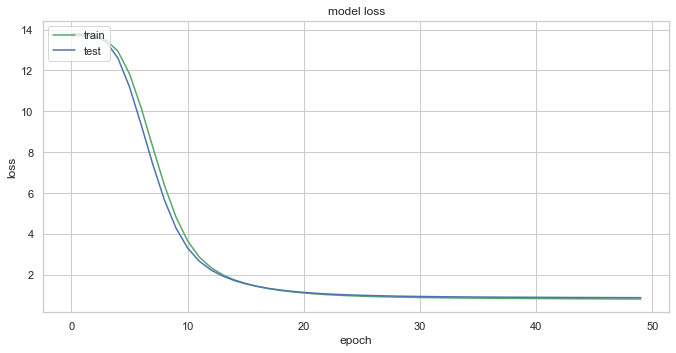

In [129]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [130]:
n_latent_factors=50
n_movies=len(df['movie_id'].unique())
n_users=len(df['user_id'].unique())

In [131]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

In [132]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [133]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

In [134]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
nn_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        47150       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        84100       ['movie_input[0][0]']            
                                                                                            

In [135]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')
batch_size=128
epochs=50

In [136]:
History = nn_model.fit([train.user_id, train.movie_id], train.rating, batch_size = batch_size,
                        epochs = epochs, validation_data = ([valid.user_id, valid.movie_id], valid.rating),
                        verbose = 1)

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 3.1137 - val_loss: 1.2672
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.3092 - val_loss: 1.0639
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 1.0915 - val_loss: 0.9706
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9828 - val_loss: 0.9315
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9240 - val_loss: 0.9094
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8815 - val_loss: 0.9027
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8475 - val_loss: 0.8959
Epoch 8/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8235 - val_loss: 0.8941
Epoch 9/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7936 - val_loss: 0.8912
Epoch 10/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7660 - val_loss: 0.8905